In [55]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import IPython
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py

In [49]:
# Generate the one hot encoded supervised dataset
ds_variation = 'negative'
output_dir = 'mnist_neg'

# make the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define the one-hot encoding function
def one_hot_encode(label, num_classes=10, random=False):
    one_hot = np.zeros(num_classes)
    if not random:
        one_hot[label] = 1
    else:
        one_hot[np.random.randint(0, num_classes)] = 1
    return one_hot

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())

# Create new datasets and copy over the data and targets
train_neg_dataset = []
test_neg_dataset = []

for dataset, neg_dataset in [(train_dataset, train_neg_dataset), (test_dataset, test_neg_dataset)]:
    for i in tqdm(range(len(dataset))):
        image, label = dataset[i]
        if ds_variation == 'positive':
            one_hot = one_hot_encode(label, random=False)
        elif ds_variation == 'negative':
            one_hot = one_hot_encode(label, random=True)
        # Replace the first 10 values in the image with the one-hot encoding
        neg_image = torch.cat((torch.tensor(one_hot), image.view(-1)[10:]))
        neg_dataset.append((neg_image, label))

train_aug_images, train_aug_labels = zip(*train_neg_dataset)
test_aug_images, test_aug_labels = zip(*test_neg_dataset)

train_neg_dataset = torch.utils.data.TensorDataset(torch.stack(train_aug_images), torch.tensor(train_aug_labels))
test_neg_dataset = torch.utils.data.TensorDataset(torch.stack(test_aug_images), torch.tensor(test_aug_labels))

# Save the datasets in hdf5 format
dataset_dir = Path(output_dir)
train_file = os.path.join(dataset_dir, 'train.hdf5')
test_file = os.path.join(dataset_dir, 'test.hdf5')

with h5py.File(train_file, 'w') as f:
    f.create_dataset('input', data=train_neg_dataset.tensors[0].numpy())
    f.create_dataset('target', data=train_neg_dataset.tensors[1].numpy())

with h5py.File(test_file, 'w') as f:
    f.create_dataset('input', data=test_neg_dataset.tensors[0].numpy())
    f.create_dataset('target', data=test_neg_dataset.tensors[1].numpy())

100%|██████████| 10000/10000 [00:01<00:00, 7941.27it/s]


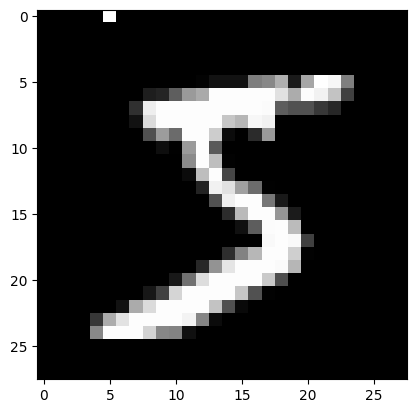

In [41]:
# Plot the first image of the train_aug_dataset with small figure size
plt.imshow(train_neg_dataset[0][0].view(28, 28), cmap='gray')

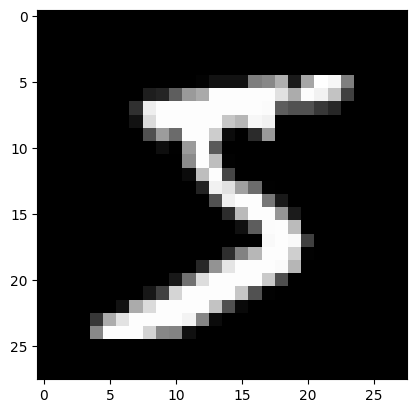

In [36]:
# Plot the first image of the train_dataset
plt.imshow(train_dataset[0][0].view(28, 28), cmap='gray')

In [59]:
# Load a HDF5 dataset
import h5py

def load_hdf5_dataset(file_path):
    with h5py.File(file_path, 'r') as f:
        input = f['input'][:]
        target = f['target'][:]
    return input, target

# Load the datasets
train_input, train_target = load_hdf5_dataset('mnist_pos/train.hdf5')
train_neg_input, train_neg_target = load_hdf5_dataset('mnist_neg/train.hdf5')

In [67]:
# Build the forward forward net

class LinearBlock(nn.Module):
    """FC block with goodness calculations"""
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc = nn.Linear(in_features, out_features)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.relu(self.fc(x))

class ForwardForwardNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 4 fully connected layers each containing 2000 ReLU's arranged using nn.Sequential
        self.block = nn.Sequential(
            LinearBlock(784, 2000),
            LinearBlock(2000, 2000),
            LinearBlock(2000, 2000),
            LinearBlock(2000, 2000),

            this architecture is wrong, working this out rn... see footnotes on page 4
        )
        # Project the 2000 output features to 10 output features and run a softmax over it
        self.softmax = nn.Softmax(dim=1)


        
    def forward(self, x):
        logits = self.block(x)
        probs = self.softmax(logits)
        return probs



m = ForwardForwardNet()

# Train the forward forward net
for i in range(5):
    # Positive pass
    x_pos = torch.randn(1, 784)
    probs = m(x_pos)
    print(probs)

    # Forward forward loss function


    # # Negative pass
    # x_neg = torch.randn(1, 784)
    # out = m(x)


tensor([[0.0986, 0.1029, 0.1023, 0.0953, 0.1008, 0.0988, 0.1017, 0.1006, 0.1001,
         0.0990]], grad_fn=<SoftmaxBackward0>)
tensor([[0.0984, 0.1020, 0.1047, 0.0960, 0.1010, 0.0984, 0.1004, 0.0998, 0.1012,
         0.0983]], grad_fn=<SoftmaxBackward0>)
tensor([[0.0969, 0.1023, 0.1029, 0.0963, 0.1020, 0.0998, 0.0999, 0.1026, 0.1005,
         0.0969]], grad_fn=<SoftmaxBackward0>)
tensor([[0.0996, 0.1016, 0.1017, 0.0965, 0.1010, 0.0997, 0.1003, 0.1006, 0.1010,
         0.0982]], grad_fn=<SoftmaxBackward0>)
tensor([[0.0977, 0.1017, 0.1034, 0.0962, 0.0985, 0.0965, 0.1003, 0.1037, 0.1021,
         0.0999]], grad_fn=<SoftmaxBackward0>)
